<h1>Traffic Based Automated Employee Scheduling for Retail Store</h1>

In [58]:

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [6]:
import sqlalchemy 
import psycopg2 
import random
import pandas as pd
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
import pyschedule
from pyschedule import Scenario, solvers, plotters, alt
sns.set(rc={'figure.figsize':(15,5)})

In [2]:
from sqlalchemy import create_engine
# Postgres username, password, and database name
POSTGRES_ADDRESS = 'vs1dbinstance.clftrceeabhm.us-east-2.rds.amazonaws.com' ## INSERT YOUR DB ADDRESS IF IT'S NOT ON PANOPLY
POSTGRES_PORT = '5432'
POSTGRES_DBNAME='vs_datascience'
POSTGRES_USERNAME = 'vs1_master_user' ## CHANGE THIS TO YOUR POSTGRES USERNAME
POSTGRES_PASSWORD = 'vs1_master_password' ## CHANGE THIS TO YOUR POSTGRES PASSWORD POSTGRES_DBNAME = 'database' ## CHANGE THIS TO YOUR DATABASE NAME
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}').format(username=POSTGRES_USERNAME,password=POSTGRES_PASSWORD,ipaddress=POSTGRES_ADDRESS,port=POSTGRES_PORT,dbname=POSTGRES_DBNAME)
# Create the connection
cnx = create_engine(postgres_str) 

Before we begin, we must define a mechanism to determine the correct number of emplyees need at a given hour in store i.e.we need to define a function which measures the effectiveness of employees present in store. This function could be "Conversion". Conversion is defined as sum of total transaction count divided by Sum of Total traffic Out at every hour of the operating hours of a retail store:

\begin{equation*} Conversion =
\left( \sum_{hour=1}^h Tc \right)/ \left( \sum_{hour=1}^h Tr \right)
\end{equation*}




where:

Tc => Transaction Count at a given hour

Tr => Customer Traffic at a given hour

h => Operating hours which is between 9:00 AM to 9:00 PM which comes out to be 12, hence h is a range of 1 to 12


The conversion above defined will be measured against a parameter. Using this parameter we will analyse conversion and understand how it varies. This parameter would be defined as Traffic to Employee Ration or TER. TER is nothing but a ratio which is defined as Average No. of Total Customer Traffic  divided by Total No. of Employees  present in Store at give hour:

\begin{equation*} TER =
\left( Tr / Emp \right)
\end{equation*}

where:

Emp => Employee present in Store

Now we need to find a GoldiLock ratio where both Conversion and TER is high. This will help us in determining how many Employees are needed to attend Customers in order to achieve high Conversion. We might not be able to choose very low TER in order to have a high conversion as this would mean that we need large number of Employees in store which would increase the overall labor related cost and every enterprise has limited budget for operating cost including labor. The below code will plot a graph between Conversion and TER (Traffic2Emp) which will help us in determining the correct TER for our Automated Scheduling

In [3]:
### Get Traffic 2 Employee Ratio and Conversion : TER vs Coversion
def get_traffic2emp_conversion():
    df_t_c= pd.read_sql_query("""
select
                ROUND(cast(a.traffic as decimal) / cast(a.employee_in_store as decimal), 2) as traffic2emp,
                ROUND(AVG(cast(a.transaction_count as decimal) / cast(a.traffic as decimal)), 2) as conversion
         from (
                  select
                         e.employee_in_store,
                         t.traffic as traffic,
                         case
                             when s.transaction_date is not null then 1
                             else 0
                             end   as transaction_count
                  from employee as e
                           INNER JOIN traffic as t
                                      ON e.time = t.time and e.date = t.date and e.city = t.city and
                                         e.country = t.country
                           inner join sales_transaction as s
                                      ON e.time =
                                         cast(date_trunc('hours', cast(cast(left(transaction_date, 7) as date) +
                                                                       cast(right(transaction_date, 5) as time) as timestamp)) as time)
                                          and e.date = cast(left(transaction_date, 7) as date)
                                          and e.city = s.city and e.country = s.country
                            where e.country='United States'
              ) a
group by ROUND(cast(a.traffic as decimal) / cast(a.employee_in_store as decimal), 2)
ORDER BY ROUND(cast(a.traffic as decimal) / cast(a.employee_in_store as decimal), 2)
""", cnx)
    return df_t_c

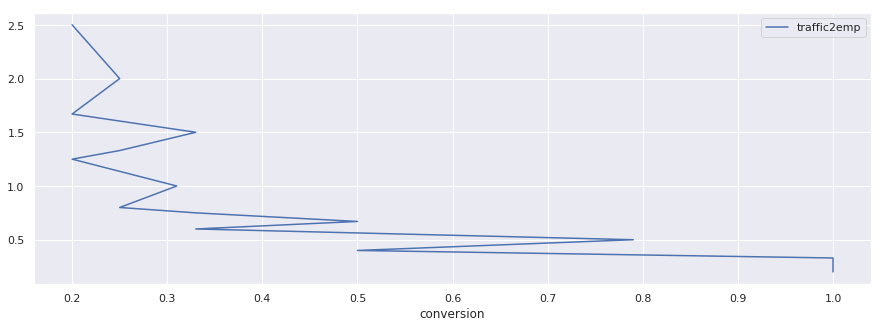

In [7]:
df_t_c=get_traffic2emp_conversion()
df_t_c.plot(kind='line',x='conversion',y='traffic2emp')

A TER of 1 would mean Average One Employee for every customer which seems little unreasonable as it would most likely raise the labor cost. Therefore lets choose the TER of <b>1.5</b> as our target for creating a Customer Traffic dependent Store Schedule. The abrupt graph is result of the synthetic data points otherwise in most cases, one would get a smooth graph as shown below:



![title](ter.png)

As seen in both the above plots, we can say that TER is inversely proprtional to Conversion and hence we need to find a balance between TER and Conversion where for a relatively high TER, there exist a reasonably high conversion, which in our case is 1.5,which means:


Lets Define Constraints now for generating schedule:

1. A Retail Store would have atleast a Store Manager (SM) and Assistant Store Manager (ASM)
2. The store will have multiple Temporary workers (TEMP) based on customer traffic attracted by store.
3. Both SM and ASM will not work more than 5 days in a week .
4. TEMP cannot work more than 6 days a week.
5. The minimum shift for any TEMP employee will be 3 hours and maximum will be 10 hours per day.
6. The minimum shift for SM and ASM will be 7 hours and maximun will be 9 hours per day.
7. The maximum number of total shift hours in a given day cannot exceed 10 hours for TEMP.
8. The operating hours for retail for store would be 9:00 AM to 9:00 PM, 7 days a week.
9. Total number of Employees in a given week cannot be more than 5.

Based on TER we can say that:
1. One in Store Employee should handle 1.5 Customer on an average for an optimum conversion
2. Two Employees should handle 1.5*2 =  3 Customers on an average
3. Three Employees should handle 1.5*3=4.5
4. Four Employees should handle anything above 4.5

In [19]:
# Get Ideal Employee requirement based on Customer Traffic at every hour
def get_emp_needed(oneEmp=1.5,twoEmp=3,threeEmp=4.5):
    df_emp_needed= pd.read_sql_query("""
select *,
       CASE
                  when a.avg_traffic <={} THEN 1
                  when a.avg_traffic <={} THEN 2
                  when a.avg_traffic <={} THEN 3
                  when a.avg_traffic > {} THEN 4
                  END as Employee_needed
from (
         select date_part('dow', date)                          as Day,
                time,
               -- state,
                round(avg(cast(traffic.traffic as decimal)), 2) as avg_traffic
         from traffic
         where 
         --state = 'England'
         country ='United States'
         and time >= '09:00:00' and time <= '21:00:00'
         group by date_part('dow', date), time --,state
     ) a
ORDER by a.Day, time;
""".format(oneEmp,twoEmp,threeEmp,threeEmp), cnx)
    return df_emp_needed

In [20]:
df_emp_needed= get_emp_needed(oneEmp=1.5,twoEmp=3,threeEmp=4.5) # TER 

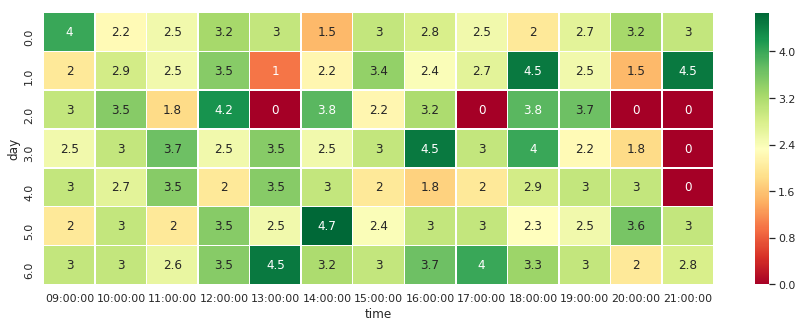

In [21]:
# Lets see the traffic pattern at hourly interval
df_avg_traffic=df_emp_needed.pivot(columns='time',values='avg_traffic',index='day')
df_avg_traffic.fillna(0,inplace=True)
sns.heatmap(df_avg_traffic, cmap='RdYlGn', linewidths=0.5, annot=True)

The above is the traffic pattern of the store. Ther x axis the operating hours of the store which is from 9:00 AM to 9:00 PM.Y-Axis is days of the week where 0 signifies Sunday and 6 is Saturday. The value in the grid reveals the average customer traffic attracted by the store at a given hour (x-axis) on given day (y-axis).

Now lets generate Employee requirement grid based on above Traffic pattern and TER.

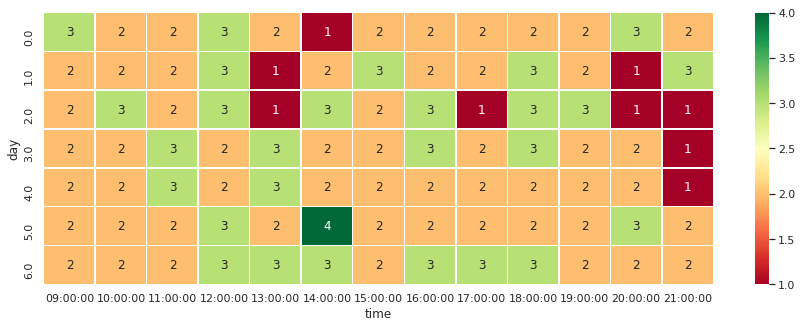

In [22]:
df_emp_needed2=df_emp_needed.pivot(columns='time',values='employee_needed',index='day')
df_emp_needed2.fillna(1,inplace=True)
sns.heatmap(df_emp_needed2, cmap='RdYlGn', linewidths=0.5, annot=True)

The above is the Employee requiement grid based on traffic and TER. Both the grids have very high correlation. The above grid can be used as base on which one needs to build Employee schedule subject to the constraints mentioned above. But before we do that lets add another contraint of budget. In real world scenario lot of things are subjected to financial constraints and hence above nmight be the ideal employee requirement but the financial constraint would force the reduction of total manhours.

For instance, the budget for store only mandates total manhours of 175 hour with -+5% laxity. Lets first calculate the total hours of the ideal requirement and the device a mechanism to reduce or increase manhoours based on explicit total hour constraint.

In [23]:
## Ideal man hours needed based on above Grid
print("Ideal weekly man hours:",df_emp_needed2.sum().sum())


Ideal weekly man hours: 202.0


As observed above we have additional 27 manhours in our schedule that we need to cut down but we still need to consider Traffic pattern for generating new schedule.
To do that we need to develop a simple back propogation model which will generate new schedule at every iteration keeping traffic pattern into consideration and then matching the total hours feeded into it.

Below is a simple back propogation function where we need to explicitly mention the total hours needed as one of the parameter of the function. This function will then tweak the TER to come up with the schedule that our budget permits. It is not necessary that the function will find an exact match but it will be close enough to the value we feed, based on the learning rate parameter.

In [24]:
## Basic Optimization using simple Back Propagation

def total_hours_known(oneEmp=1.5,twoEmp=3,threeEmp=4.5,total_hours=220,learning_rate=0.1):
    oneEmp_local=oneEmp
    twoEmp_local=twoEmp
    threeEmp_local=threeEmp
    oneEmp_local_old=0
    twoEmp_local_old=0
    threeEmp_local_old=0
    increaseParameters=''
    decreaseParameters=''
    opt_sol_flag=""
    n=0
    
    while opt_sol_flag=="":
        n=n+1
        print(oneEmp_local,twoEmp_local)
        df_store_sch=get_emp_needed(oneEmp=oneEmp_local,twoEmp=twoEmp_local,threeEmp=threeEmp_local)
      #  print("1", df_store_sch.employee_needed.sum())
        df_store_sch=df_store_sch.pivot(columns='time',values='employee_needed',index='day')
        df_store_sch.fillna(1,inplace=True)
        print("Total Hours:",df_store_sch.sum().sum(), "n=",n)
        
        if (increaseParameters=='X') & (decreaseParameters=='X'):
            break
        elif df_store_sch.sum().sum()==total_hours:
            break
        elif df_store_sch.sum().sum()<total_hours:
            oneEmp_local_old=oneEmp_local
            twoEmp_local_old=twoEmp_local
            threeEmp_local_old=threeEmp_local
            
            if oneEmp_local > learning_rate:
                oneEmp_local=round(oneEmp_local-learning_rate,2)
            if twoEmp_local > learning_rate:
                twoEmp_local=round(twoEmp_local-learning_rate,2)
            if threeEmp_local > learning_rate:
                threeEmp_local=round(threeEmp_local-learning_rate,2)    
            decreaseParameters='X'
            continue
        elif df_store_sch.sum().sum()>total_hours:
            oneEmp_local_old=oneEmp_local
            twoEmp_local_old=twoEmp_local
            oneEmp_local=round(oneEmp_local+learning_rate,2)
            twoEmp_local=round(twoEmp_local+learning_rate,2)
            threeEmp_local=round(threeEmp_local+learning_rate,2)
            increaseParameters='X'
            continue
        elif n==360: # Safety against Endless Loop 
            break
            
    latest_parameters_sum=df_store_sch.sum().sum()
    df_store_sch=get_emp_needed(oneEmp=oneEmp_local_old,twoEmp=twoEmp_local_old,threeEmp=threeEmp_local_old)
    df_store_sch=df_store_sch.pivot(columns='time',values='employee_needed',index='day')
    old_parameters_sum=df_store_sch.sum().sum()
    latest_parameters_sum=abs(latest_parameters_sum-total_hours)
    old_parameters_sum=abs(old_parameters_sum-total_hours)
    
    if latest_parameters_sum > old_parameters_sum:
        print("Optimized Solution found: oneEmp:",oneEmp_local_old, "twoEmp:", twoEmp_local_old,"threeEmp:",threeEmp_local_old)
        df_store_sch=get_emp_needed(oneEmp=oneEmp_local_old,twoEmp=twoEmp_local_old,threeEmp=threeEmp_local_old)
    else:
        print("Optimized Solution found: oneEmp:",oneEmp_local, "twoEmp:", twoEmp_local,"threeEmp:",threeEmp_local )
        df_store_sch=get_emp_needed(oneEmp=oneEmp_local,twoEmp=twoEmp_local,threeEmp=threeEmp_local)
        
    return df_store_sch

In [25]:
## Generating new schedule based on total_hours, default learning rate=0.1

df_emp_needed=total_hours_known(total_hours=175)

1.5 3
Total Hours: 202.0 n= 1
1.6 3.1
Total Hours: 202.0 n= 2
1.7 3.2
Total Hours: 199.0 n= 3
1.8 3.3
Total Hours: 196.0 n= 4
1.9 3.4
Total Hours: 192.0 n= 5
2.0 3.5
Total Hours: 177.0 n= 6
2.1 3.6
Total Hours: 176.0 n= 7
2.2 3.7
Total Hours: 171.0 n= 8
2.1 3.6
Total Hours: 176.0 n= 9
Optimized Solution found: oneEmp: 2.1 twoEmp: 3.6 threeEmp: 5.1


As seen above, an optimized solution is found. Now, lets see the new schedule heatmap.

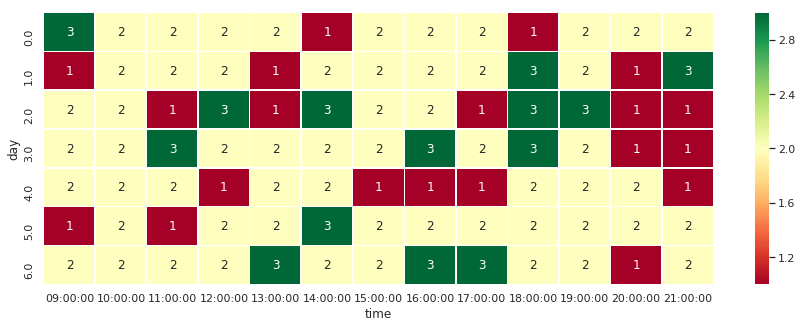

In [26]:
df_emp_needed2=df_emp_needed.pivot(columns='time',values='employee_needed',index='day')
df_emp_needed2.fillna(1,inplace=True)
sns.heatmap(df_emp_needed2, cmap='RdYlGn', linewidths=0.5, annot=True)

The above grid is our input, now we need to subject the above schedule to the scheduling constraints we have and generate a feasible schedule. There would be many scenarios where we might not get any solution but we need find a feasible solution by tweaking as few constraints as possible. The hard constraints that mentiioned above will be preserved and the actual tweaking will happend with respect to the traffic allocation.

For finding a schedule, we will requie a solver. I  this case we will be using CBC solver that comes with package PuLP. For constrains we will be using a Python Library called "PySchedule".

First we will allocate total number of employees for a given day and the we will optimize the hourly schedule for a given day.

The below functions are the actual engine of this automated scheduling.

In [27]:
## Maximum Employees needed on a given day based on total manhours for that day
def getMaxEmpNeeded(i,df,two=18,three=25,four=40):
    
    emp_needed=1
        
    if df.loc[df.index==i].transpose().sum().values[0].astype(int) < two:
        emp_needed=2
    elif df.loc[df.index==i].transpose().sum().values[0].astype(int) < three: 
        emp_needed=3
    elif df.loc[df.index==i].transpose().sum().values[0].astype(int) < four: 
        emp_needed=4
    else:
        emp_needed=5
        
    if  df.loc[df.index==i].transpose().max().values[0].astype(int) > emp_needed:
        emp_needed = df.loc[df.index==i].transpose().max().values[0].astype(int)
        
    return emp_needed

In [29]:
## Get Actual Employee allocation at day level
def getDayAllocation(employee_names,shift_requirements,n_days=7,max_seq=5,min_seq=1,max_work=6,min_work=3,max_weekend=2):

    #n_days = 7  # number of days
    days = list(range(n_days))
    #max_seq = 5  # max number of consecutive shifts
    #min_seq = 1  # min sequence without gaps
    #max_work = 6  # max total number of shifts
    #min_work = 3  # min total number of shifts
    #max_weekend = 2  # max number of weekend shifts

    # Create employee scheduling scenari
    S = Scenario('employee_scheduling', horizon=n_days)

    # Create employees as resources indexed by namesc
    employees = {name: S.Resource(name) for name in employee_names}

    # Create shifts as tasks
    shifts = {(day, i): S.Task('S_%s_%s' % (str(day), str(i)))
              for day in shift_requirements if day in days
              for i in range(shift_requirements[day])}

    # distribute shifts to days
    for day, i in shifts:
        # Assign shift to its day
        S += shifts[day, i] >= day
        # The shifts on each day are interchangeable, so add them to the same group
        shifts[day, i].group = day
        # Weekend shifts get attribute week_end
        if day % 7 in {0, 6}:  # it was {5,6}
            shifts[day, i].week_end = 1

    # There are no restrictions, any shift can be done by any employee
    for day, i in shifts:
        shifts[day, i] += alt(S.resources())
        # print(shifts[day,i],alt( S.resources() ))

    # Capacity restrictions
    for name in employees:
        if (name == 'SM' or name == 'ASM'):
            # Maximal number of shifts
            S += employees[name] <= 5
            # Minimal number of shifts
            S += employees[name] >= 5
            # Maximal number of weekend shifts using attribute week_end
            S += employees[name]['week_end'] <= 1
        else:
            # Maximal number of shifts
            S += employees[name] <= max_work
            # Minimal number of shifts
            S += employees[name] >= min_work
            # Maximal number of weekend shifts using attribute week_end
            S += employees[name]['week_end'] <= max_weekend

    # Max number of consecutive shifts
    for name in employees:
        for day in range(n_days):
            S += employees[name][day:day + max_seq + 1] <= max_seq

    # Min sequence without gaps
    for name in employees:
        # No increase in last periods
        S += employees[name][n_days - min_seq:].inc <= 0
        # No decrease in first periods
        S += employees[name][:min_seq].dec <= 0
        # No diff during time horizon
        for day in days[:-min_seq]:
            S += employees[name][day:day + min_seq + 1].diff <= 1

    # Solve and plot scenario
    d={}
    if solvers.mip.solve(S, kind='CBC', msg=0, random_seed=6):

       # plotters.matplotlib.plot(S, fig_size=(12, 5))
        solutionList = S.solution()
        for tup in solutionList:
            d.setdefault(tup[2] + 1, []).append(str(tup[1]))
    else:
        print('no solution found')


    return(d)

In [30]:
schDict={}
for i in range(df_emp_needed2.shape[0]):
    schDict.update({i: getMaxEmpNeeded(i,df_emp_needed2)})
print(schDict)    

{0: 4, 1: 4, 2: 4, 3: 4, 4: 3, 5: 4, 6: 4}


The above dictionary tells us the total number of employees needed for a given day. Key is day of the week and value is the total number of employees needed. For example on Sunday which is denoted by key "0" , the store needs total of 4 employees.

In [31]:
availabilityMatrix={}
for i in [['SM','ASM','TEMP1'],['SM','ASM','TEMP1','TEMP2'],['SM','ASM','TEMP1','TEMP2','TEMP3']]:
    availabilityMatrix=getDayAllocation(i, schDict)
    if len(availabilityMatrix) > 0:
        break
print(availabilityMatrix)

no solution found
no solution found
{1: ['ASM', 'TEMP1', 'TEMP2', 'TEMP3'], 2: ['SM', 'ASM', 'TEMP2', 'TEMP3'], 3: ['ASM', 'TEMP1', 'TEMP2', 'TEMP3'], 4: ['SM', 'ASM', 'TEMP1', 'TEMP3'], 5: ['SM', 'ASM', 'TEMP1'], 6: ['SM', 'TEMP1', 'TEMP2', 'TEMP3'], 7: ['SM', 'TEMP1', 'TEMP2', 'TEMP3']}


The above list tells us who exactly is allocated which day to work.

In [32]:
def find_feasible_sch(employee_names, n_hours, hours, max_seq,min_seq,max_work,min_work,shift_requirements,Weekday):
    
    ## Return variable
    df=pd.DataFrame(columns=['Title', 'TimeSlot','Available','Day'])
    feasibility_flag=''
    shift_requirements2=shift_requirements
    for i in shift_requirements:
        try:
            if shift_requirements[i-1]==shift_requirements[i+1]:
                if shift_requirements[i-1] != shift_requirements[i]:
                    shift_requirements[i]=shift_requirements[i-1]
                    feasibility_flag='X'
                    break
        except:
            continue
    if feasibility_flag=='':
        shift_requirements, feasibility_flag = find_feasible_sch2(shift_requirements2)
        if feasibility_flag=='X':
        #    print("Feasible Solution:",shift_requirements) 
         df =  build_schedule(employee_names,n_hours,hours, 
                   max_seq,min_seq,max_work,min_work,shift_requirements,Weekday)
    else:    
      #  print("Feasible Solution:",shift_requirements) 
        df=build_schedule(employee_names,n_hours,hours, 
                   max_seq,min_seq,max_work,min_work,shift_requirements,Weekday) 
    
    return df

In [33]:
def find_feasible_sch2(shift_requirements):
    feasibility_flag=''
    for i in shift_requirements:
        try:
            if (shift_requirements[i]!=shift_requirements[i+1]):
                shift_requirements[i]=shift_requirements[i+1]
                feasibility_flag='X'
                break
        except:
            continue
    if feasibility_flag=='':
        print(shift_requirements)
        print("No feasible solution")
    
    return(shift_requirements, feasibility_flag)

In [34]:
def build_schedule(employee_names, n_hours, hours, max_seq,min_seq,max_work,min_work,shift_requirements,Weekday):
    
    ## Return variable
    df=pd.DataFrame(columns=['Title', 'TimeSlot','Available','Day'])
    
    # Create employee scheduling scenarios
    S = Scenario('employee_scheduling',horizon=n_hours)

# Create enployees as resources indexed by namesc
    employees = { name : S.Resource(name) for name in employee_names }

# Create shifts as tasks
    shifts = { (day,i) : S.Task('S_%s_%s'%(str(day),str(i))) 
          for day in shift_requirements if day in hours
          for i in range(shift_requirements[day]) }

# distribute shifts to days
    for day,i in shifts:
    # Assign shift to its day
        S += shifts[day,i] >= day
    # The shifts on each day are interchangeable, so add them to the same group
        shifts[day,i].group = day
    # Weekend shifts get attribute week_end
      #  if day % 7 in {5,6}:
        #    shifts[day,i].week_end = 1

# There are no restrictions, any shift can be done by any employee
    for day,i in shifts:
        shifts[day,i] += alt( S.resources() )
    
# Capacity restrictions
    for name in employees:
        if name=='SM' or name=='ASM':
    # Maximal number of shifts
            S += employees[name] <= 9
    # Minimal number of shifts
            S += employees[name] >= 7      
        else:
          #  print(min_work,max_work)
    # Maximal number of shifts
            S += employees[name] <= max_work
    # Minimal number of shifts
            S += employees[name] >= min_work
    # Maximal number of weekend shifts using attribute week_end
         #   S += employees[name]['week_end'] <= max_weekend
    

# Max number of consecutive shifts
    for name in employees:
        for day in range(n_hours):
            S += employees[name][day:day+max_seq+1] <= max_seq

# Min sequence without gaps
    for name in employees:
        if (name=='SM' or name =='ASM'):
            min_seq2=8
        # No increase in last periods
            S += employees[name][n_hours-min_seq2:].inc <= 0
    # No decrease in first periods
            S += employees[name][:min_seq2].dec <= 0
    # No diff during time horizon
            for day in hours[:-min_seq2]:
                S += employees[name][day:day+min_seq2+1].diff <= 1
        else:        
    # No increase in last periods
            S += employees[name][n_hours-min_seq:].inc <= 0
    # No decrease in first periods
            S += employees[name][:min_seq].dec <= 0
    # No diff during time horizon
            for day in hours[:-min_seq]:
                S += employees[name][day:day+min_seq+1].diff <= 1
        
# Solve and plot scenario
    if solvers.mip.solve(S,kind='CBC',msg=0,random_seed=6):
      #  %matplotlib inline
        plotters.matplotlib.plot(S,fig_size=(12,5))
        solutionList=S.solution()
        sList=[]
        for i in solutionList:
            sList.append(tuple((str(i[1]),i[2]+9,1,Weekday)))
        df=pd.DataFrame(sList, columns=['Title', 'TimeSlot','Available','Day']) 
        print("Feasible total_hours:", df.Available.sum())
        df2=df.pivot(columns='TimeSlot',values='Available',index='Title')
        df2.fillna(0,inplace=True)
      #  sns.heatmap(df2, cmap='Pastel2', linewidths=0.5, annot=True)
    else:
        print('no solution found')
        df=find_feasible_sch(employee_names, n_hours, hours, max_seq,min_seq,max_work,min_work,shift_requirements,Weekday)
        
    return(df)

################################
Schedule for  Sunday
Employee Availability : ['ASM', 'TEMP1', 'TEMP2', 'TEMP3']
Ideal Hourly need: [3. 2. 2. 2. 2. 1. 2. 2. 2. 1. 2. 2. 2.]
Ideal Total Hours: 25.0
no solution found
no solution found
no solution found


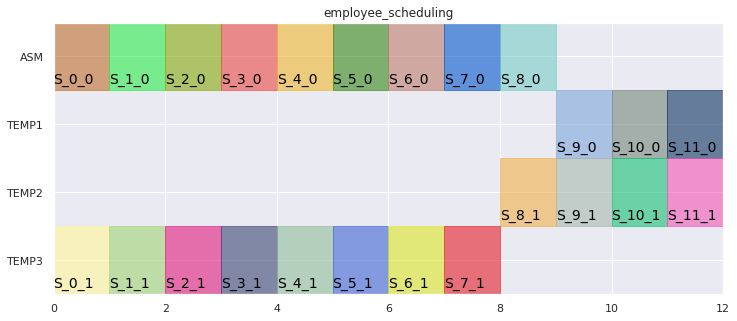

Feasible total_hours: 24
################################
Schedule for  Monday
Employee Availability : ['SM', 'ASM', 'TEMP2', 'TEMP3']
Ideal Hourly need: [1. 2. 2. 2. 1. 2. 2. 2. 2. 3. 2. 1. 3.]
Ideal Total Hours: 25.0
no solution found


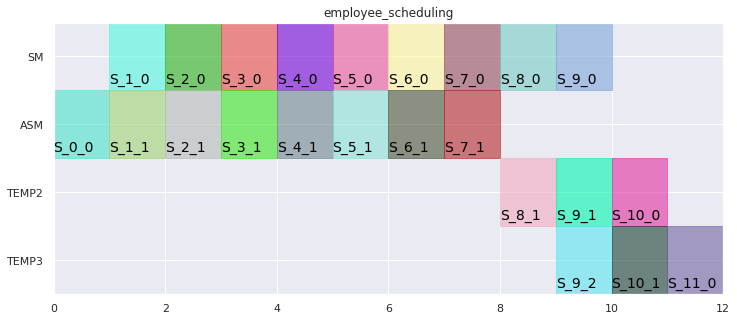

Feasible total_hours: 23
################################
Schedule for  Tuesday
Employee Availability : ['ASM', 'TEMP1', 'TEMP2', 'TEMP3']
Ideal Hourly need: [2. 2. 1. 3. 1. 3. 2. 2. 1. 3. 3. 1. 1.]
Ideal Total Hours: 25.0
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found


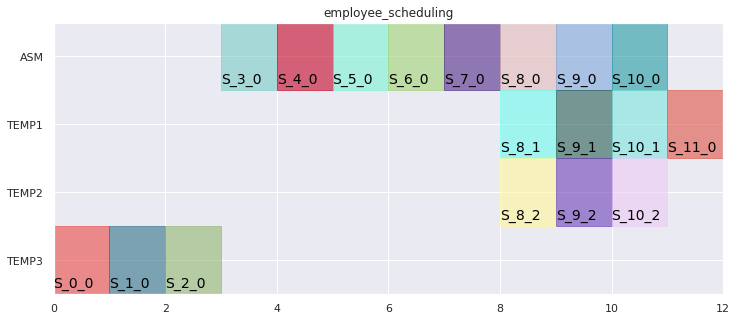

Feasible total_hours: 18
################################
Schedule for  Wednesday
Employee Availability : ['SM', 'ASM', 'TEMP1', 'TEMP3']
Ideal Hourly need: [2. 2. 3. 2. 2. 2. 2. 3. 2. 3. 2. 1. 1.]
Ideal Total Hours: 27.0


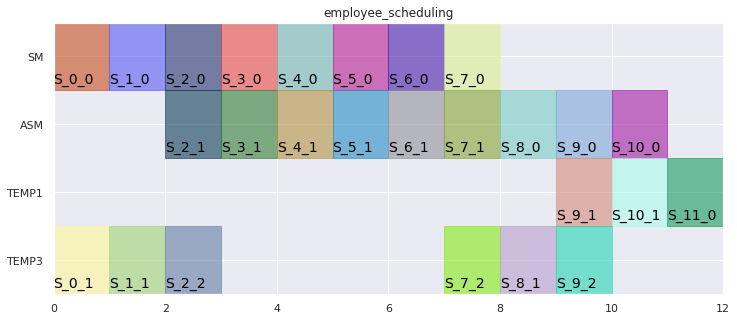

Feasible total_hours: 26
################################
Schedule for  Thursday
Employee Availability : ['SM', 'ASM', 'TEMP1']
Ideal Hourly need: [2. 2. 2. 1. 2. 2. 1. 1. 1. 2. 2. 2. 1.]
Ideal Total Hours: 21.0
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found
no solution found


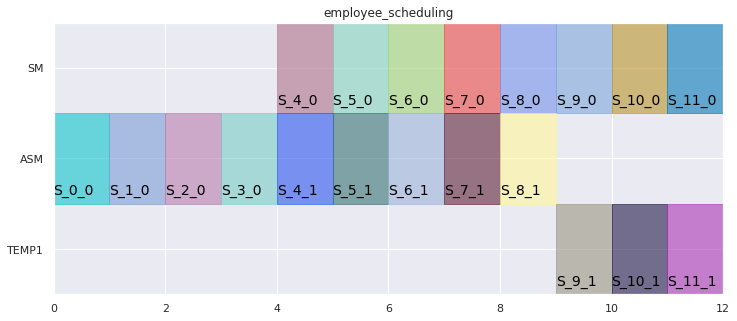

Feasible total_hours: 20
################################
Schedule for  Friday
Employee Availability : ['SM', 'TEMP1', 'TEMP2', 'TEMP3']
Ideal Hourly need: [1. 2. 1. 2. 2. 3. 2. 2. 2. 2. 2. 2. 2.]
Ideal Total Hours: 25.0
no solution found


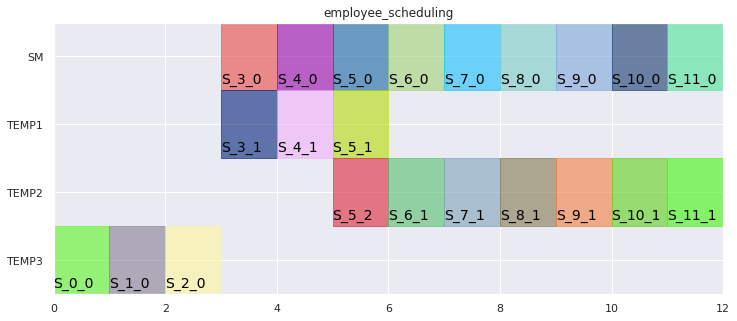

Feasible total_hours: 22
################################
Schedule for  Saturday
Employee Availability : ['SM', 'TEMP1', 'TEMP2', 'TEMP3']
Ideal Hourly need: [2. 2. 2. 2. 3. 2. 2. 3. 3. 2. 2. 1. 2.]
Ideal Total Hours: 28.0


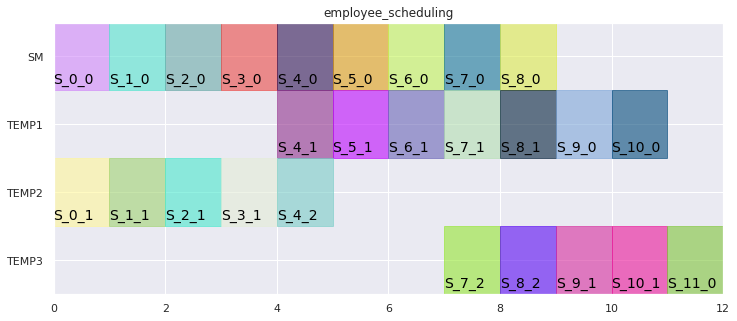

Feasible total_hours: 26


In [35]:
# WeekdayDictionary
dayDict={1 : 'Sunday',2 : 'Monday',3 : 'Tuesday',4 : 'Wednesday', 5 :'Thursday', 6:'Friday',7:'Saturday'}

# Employee Availability Matrix
#availabilityMatrix = {1:['ASM','KH','HE1','HE2'],2:['SM','ASM','HE2'],3:['ASM','KH','HE1'],4:['SM','KH','HE2'],
 #                    5:['SM','KH','HE1'],6:['SM','ASM','KH'],7:['SM','KH','HE1','ASM']}

# Dictionary  for Shift Requirement with dummy values
shift_requirements =\
{0: 2,1: 2,2: 2,3: 2,4: 3,5: 3,6: 3, 7: 3,8: 3,9: 2,10: 2,11: 2}

# Constraints
n_hours = 12 # Total number of hours in a days for which store would be open
hours = list(range(n_hours))
max_seq = 9 # max number of consecutive shifts
min_seq = 3 # min sequence without gaps
max_work = 10 # max total number of shifts
min_work = 3 # min total number of shifts

df_solution=pd.DataFrame(columns=['Title', 'TimeSlot','Available','Day'])

for (idx, row) in df_emp_needed2.iterrows():
    print("################################")
    print("Schedule for ",dayDict[idx+1])
    print("Employee Availability :",availabilityMatrix[idx+1])
    employee_names=availabilityMatrix[idx+1]
   # print(row)
    key=0
    for i in row.astype('int').values:
        shift_requirements[key] = i
        key=key+1
    print("Ideal Hourly need:", row.values)
    print("Ideal Total Hours:",row.values.sum())
    df=build_schedule(employee_names,n_hours,hours, 
                   max_seq,min_seq,max_work,min_work,shift_requirements,idx) 
    if df.shape[0] > 1:
        df_solution=df_solution.append(df)
        


The above is the automated schedule generated by the system. Lets see each schedule in detail, below:


In [49]:
def get_weekday_sch(day,df):
    
    df2=df.loc[df['Day']==day]
    df2=df2.pivot(columns='TimeSlot',values='Available',index='Title')
    df2.fillna(0,inplace=True)
 ##   print("Schedule for ",dayDict[day])
    return df2

####### Schedule for Sunday #######


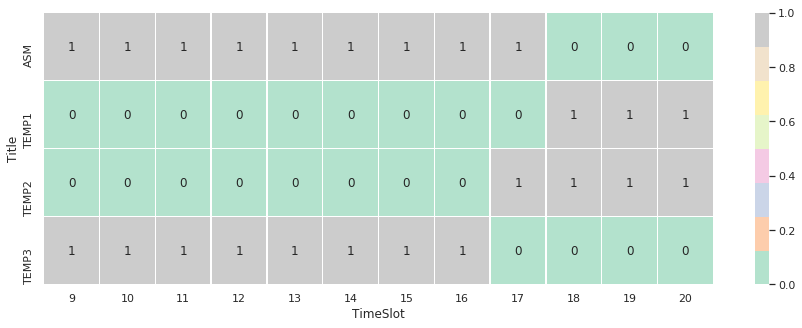

In [50]:
df_schd=get_weekday_sch(0,df_solution)
sns.heatmap(df_schd, cmap='Pastel2', linewidths=0.5, annot=True)
print("#######",'Schedule for Sunday','#######')

####### Schedule for Monday #######


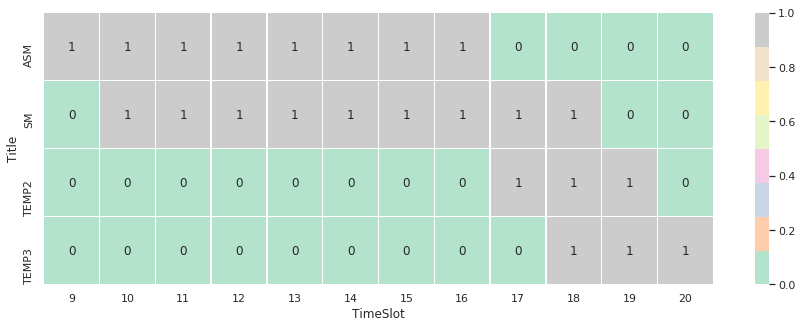

In [52]:
df_schd=get_weekday_sch(1,df_solution)
sns.heatmap(df_schd, cmap='Pastel2', linewidths=0.5, annot=True)
print("#######",'Schedule for Monday','#######')

####### Schedule for Tuesday #######


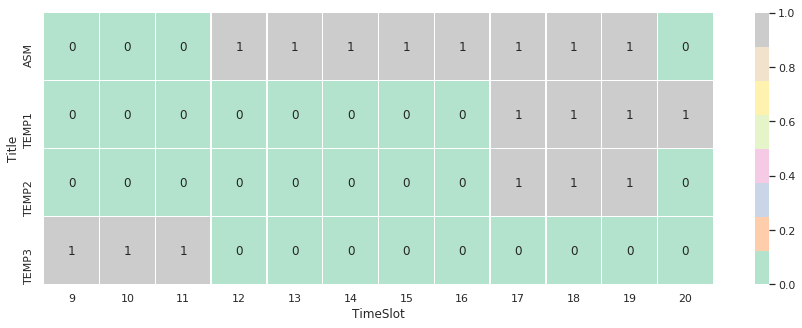

In [53]:
df_schd=get_weekday_sch(2,df_solution)
sns.heatmap(df_schd, cmap='Pastel2', linewidths=0.5, annot=True)
print("#######",'Schedule for Tuesday','#######')

####### Schedule for Wednesday #######


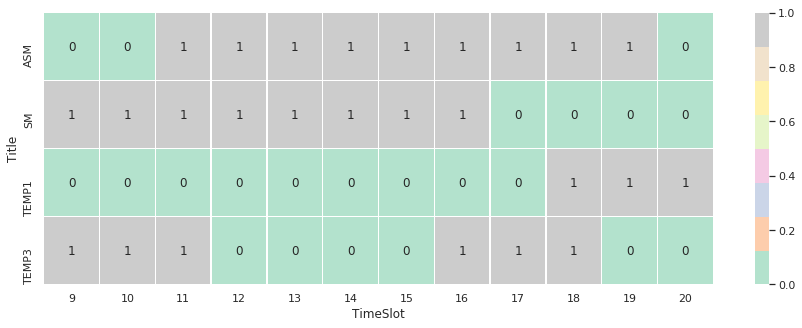

In [54]:
df_schd=get_weekday_sch(3,df_solution)
sns.heatmap(df_schd, cmap='Pastel2', linewidths=0.5, annot=True)
print("#######",'Schedule for Wednesday','#######')

####### Schedule for Thursday #######


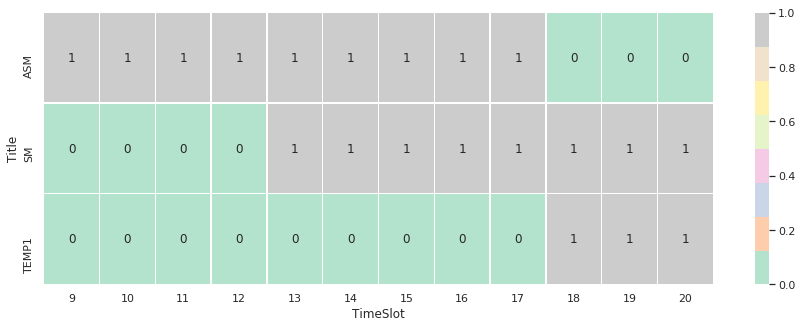

In [55]:
df_schd=get_weekday_sch(4,df_solution)
sns.heatmap(df_schd, cmap='Pastel2', linewidths=0.5, annot=True)
print("#######",'Schedule for Thursday','#######')

####### Schedule for Friday #######


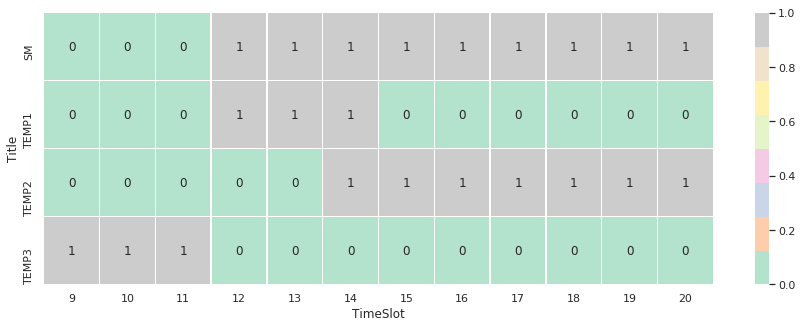

In [56]:
df_schd=get_weekday_sch(5,df_solution)
sns.heatmap(df_schd, cmap='Pastel2', linewidths=0.5, annot=True)
print("#######",'Schedule for Friday','#######')

####### Schedule for Saturday #######


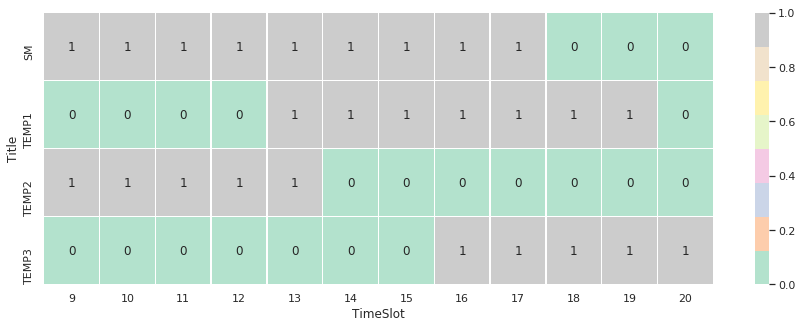

In [57]:
df_schd=get_weekday_sch(6,df_solution)
sns.heatmap(df_schd, cmap='Pastel2', linewidths=0.5, annot=True)
print("#######",'Schedule for Saturday','#######')